# PFAS Toolbox -  Temporal Analysis of Industries

This task is to conduct the analysis of temporal effects of industries. We would like to see which industries have had fairly consistent PFAS concentrations (individually and totally) over time in order to determine which industries we should continue to monitor over time and which already have a stable baseline. 

### 1) Libraries Import (REQUIRED)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import chardet
import seaborn as sns
import openpyxl 
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, FixedFormatter
import scipy.stats as stats
from matplotlib.ticker import AutoMinorLocator
from matplotlib.font_manager import FontProperties
from scipy.stats import linregress
import matplotlib.dates as mdates

### 2) Data Import and Export (REQUIRED)

#### Define Functions for Data Import and Export (Required)

In [2]:
def read_excel_sheet(excel_file, sheet_name):
    """
    Read a specific sheet from an Excel file into a DataFrame.

    Args:
        excel_file (str): The path to the Excel file.
        sheet_name (str): The name of the sheet to read.

    Returns:
        pd.DataFrame or None: A DataFrame containing the sheet data or None if the sheet is not found.
    """
    try:
        # Load the specified sheet from the Excel file into a DataFrame
        df = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=1)
        return df
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [3]:
def dfs_to_excel(dfs, filename):
    """
    Write an array of dataframes to separate tabs in an Excel file.
    
    Parameters:
    - dfs: A dictionary where keys are the tab names and values are the DataFrames to write.
    - filename: The name of the Excel file to write to.
    """
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        for tab_name, df in dfs.items():
            # Write each dataframe to a separate sheet
            df.to_excel(writer, sheet_name=tab_name)
    
    print(f"File '{filename}' has been written with {len(dfs)} tabs.")

#### OPTION 1) Import Data from Excel Macro

In [20]:
# Example usage:

#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Database as of 01-09-2025.xlsm'
#Specify sheet name
sheet_name = 'PFAS Database'

#Call data import function
data_df = read_excel_sheet(excel_file_path, sheet_name)

data_df.head()

,Sampling point Date Component,Sample Number,Sampling Point,Sample Name,Sampled Date,Analysis,Component,Qualifiers,Result,Units,...,ChainLength,Pseudonym,Dominant Contributor,Sector,Depth,Edit Notes,Field,Notes,Region,Crop
0,ANODIZE SOLUTIONS (FPT)-43692.3333333333-10:2F...,259452.0,ANODIZE SOLUTIONS (FPT),NaN,2019-08-15 08:00:00,PFAS-CL,10:2Fluorotelomersulfonic Acid (Report),NaN,<9.40,ppt_wt_v,...,12.0,Metal Finisher B,NaN,Metal Finishing,NaN,NaN,NaN,NaN,NaN,NaN
1,ANODIZE SOLUTIONS (FPT)-43692.3333333333-11Cl-...,259452.0,ANODIZE SOLUTIONS (FPT),NaN,2019-08-15 08:00:00,PFAS-CL,11Cl-PF3OUdS (Report),NaN,<4.70,ppt_wt_v,...,10.0,Metal Finisher B,NaN,Metal Finishing,NaN,NaN,NaN,NaN,NaN,NaN
2,ANODIZE SOLUTIONS (FPT)-43692.3333333333-4:2Fl...,259452.0,ANODIZE SOLUTIONS (FPT),NaN,2019-08-15 08:00:00,PFAS-CL,4:2Fluorotelomersulfonic Acid (Report),NaN,<4.70,ppt_wt_v,...,6.0,Metal Finisher B,NaN,Metal Finishing,NaN,NaN,NaN,NaN,NaN,NaN
3,ANODIZE SOLUTIONS (FPT)-43692.3333333333-6:2Fl...,259452.0,ANODIZE SOLUTIONS (FPT),NaN,2019-08-15 08:00:00,PFAS-CL,6:2Fluorotelomersulfonic Acid (Report),NaN,<19.0,ppt_wt_v,...,8.0,Metal Finisher B,NaN,Metal Finishing,NaN,NaN,NaN,NaN,NaN,NaN
4,ANODIZE SOLUTIONS (FPT)-43692.3333333333-8:2Fl...,259452.0,ANODIZE SOLUTIONS (FPT),NaN,2019-08-15 08:00:00,PFAS-CL,8:2Fluorotelomersulfonic Acid (Report),NaN,<9.40,ppt_wt_v,...,10.0,Metal Finisher B,NaN,Metal Finishing,NaN,NaN,NaN,NaN,NaN,NaN


### Figures Settings

In [155]:
# Set default tick label size
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

# Set default font size for title, labels, and legend
plt.rcParams['axes.titlesize'] = 30  # Set the font size for plot titles
plt.rcParams['axes.labelsize'] = 24  # Set the font size for axis labels
plt.rcParams['legend.fontsize'] = 20  # Set the font size for legend

# Set default font family to Aria
plt.rcParams['font.family'] = 'Arial'

# Set default font type for plot titles to bold
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

### 3) Import Other Data (REQUIRED)

In [133]:
# Import PFAS Attributes
#Specify sheet name
sheet_name = 'PFAS Attributes'

df_PFAS_Attributes = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Remove rows where 'Database' column contains the text 'TOP'
df_PFAS_Attributes = df_PFAS_Attributes[~df_PFAS_Attributes['Database'].str.contains('TOP', na=False)]

df_PFAS_Attributes = df_PFAS_Attributes.drop_duplicates(subset='Abbrev', keep='first')

# Create a dictionary mapping PFAS Compounds to their corresponding Abbreviation (No need to change)
pfas_mapping = dict(zip(df_PFAS_Attributes['Database'], df_PFAS_Attributes['Abbrev']))

def parse_rgb(rgb_string):
    # Check if rgb_string is a string and not empty
    if isinstance(rgb_string, str) and rgb_string:
        # Remove parentheses and split the string by commas
        rgb_values = rgb_string.strip('()').split(',')
        # Convert each value to float and return as a tuple
        return tuple(int(value)/255 for value in rgb_values)
    else:
        # Handle the case where rgb_string is not a string or is empty
        return None  # or return (0, 0, 0, 0) for a default transparent color, for example



# Create a dictionary with PFAS compounds as keys and corresponding colors as values
compound_colors_dict = {compound: parse_rgb(rgb) for compound, rgb in zip(df_PFAS_Attributes['Database'], df_PFAS_Attributes['RGB'])}
compound_colors_dict_abbrev = {abbrev: parse_rgb(rgb) for abbrev, rgb in zip(df_PFAS_Attributes['Abbrev'], df_PFAS_Attributes['RGB'])}

In [187]:
desired_order=['3:3FTCA', '5:3FTCA', '7:3FTCA', 'PFBA', 'PFPeA', 'PFHxA', 'PFHpA', 'PFOA', 'PFNA', 'PFDA', 'PFUnA', 'PFDoA', 'PFTrDA', 'PFTeDA', 'PFHxDA', 'PFODA', 'NEtFOSAA', 'NMeFOSAA', 'PFBS', 'PFPeS', 'PFHxS', 'PFHpS', 'PFOS', 'PFNS', 'PFDS', 'PFDoS', 'PFMPA', 'HFPO-DA', 'NFDHA', 'PFMBA', 'ADONA', '4:2FTS', '6:2FTS', '8:2FTS', '10:2FTS', 'NEtFOSA', 'NMeFOSA', 'FOSA', 'NEtFOSE', 'NMeFOSE', 'PFEESA', '9Cl-PF3ONS', '11Cl-PF3OUdS', 'AOF']


In [25]:
def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, add_data_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        fig, ax1 = plt.subplots(figsize=figsize)

        # Stacked Bar Plot
        bottom = np.zeros(len(avg_pivot_table_filtered.index))
        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table_filtered.get(compound, np.zeros_like(avg_values)) if std_dev_pivot_table is not None else np.zeros_like(avg_values)
            ax1.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color, label=compound, yerr=std_dev_values, capsize=0)
            bottom += avg_values

        # Scatter Plot with Trendline for Total PFAS
        #if 'Total PFAS' in add_data_table.columns:
         #   scatter_x = add_data_table.index
          #  scatter_y = add_data_table['Total PFAS']
           # ax1.scatter(scatter_x, scatter_y, color='black', label='Total PFAS', zorder=5)

            # Calculate trendline
            #slope, intercept, r_value, p_value, std_err = linregress(range(len(scatter_x)), scatter_y)
            #line = slope * np.arange(len(scatter_x)) + intercept
            #ax1.plot(scatter_x, line, 'r--', label=f'Trendline: y={slope:.2f}x+{intercept:.2f}\nR²={r_value**2:.2f}\np-value = {p_value:.2f}')

        ax1.set_ylim(0, ylim)
        ax1.set_xlabel('Date (Month and Year)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_title(title, fontsize=title_fontsize, fontproperties=font_bold, pad=20)
        ax1.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)
        
        # Combine legend handles and labels from both axes
        handles1, labels1 = ax1.get_legend_handles_labels()

        all_handles = handles1 
        all_labels = labels1
        
        ax1.legend(handles=all_handles, labels=all_labels, title='Legend', bbox_to_anchor=(1.05, 1.05), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


### Dataset Prep

In [38]:
# Define the type or types you want to filter by
types_to_include = ['Outfall of Industry']  # replace with the types you're interested in
# Create the mask for types
type_mask = data_df['Type'].isin(types_to_include)
# Apply both masks to filter the dataframe
filtered_df = data_df[type_mask]

#Define quality grades to include
qual_grades=['Good', 'Probably Ok', 'Probably ok','probably ok']
# Create mask for quality 
qual_mask = filtered_df['Qual Summary (Grade for filtering)'].isin(qual_grades)
# Apply mask to filter the dataframe
filtered_df = filtered_df[qual_mask]

#Identify compounds in both methods
compounds_in_both = df_PFAS_Attributes[(df_PFAS_Attributes['EPA Method 1633'] == 'X') & (df_PFAS_Attributes['EPA Method 537.1'] == 'X')]['Database'].tolist()
compounds_mask=filtered_df['PFAS Compound'].isin(compounds_in_both)
# Apply mask to filter the dataframe
filtered_df = filtered_df[compounds_mask]

sample_locations=filtered_df['Sample Location'].unique()
compounds=filtered_df['PFAS Compound'].unique()

In [39]:
compounds

array(['11Cl-PF3OUdS', '4:2 Fluorotelomersulfonic acid',
       '6:2 Fluorotelomersulfonic acid', '8:2 Fluorotelomersulfonic acid',
       '9Cl-PF3ONS', 'ADONA', 'HFPO-DA', 'NEtFOSAA', 'NMeFOSAA',
       'Perfluorobutanesulfonic acid', 'Perfluorobutanoic acid',
       'Perfluorodecanesulfonic acid', 'Perfluorodecanoic acid',
       'Perfluorododecanesulfonic acid', 'Perfluorododecanoic acid',
       'Perfluoroheptanesulfonic acid', 'Perfluoroheptanoic acid',
       'Perfluorohexanesulfonic acid', 'Perfluorohexanoic acid',
       'Perfluorononanesulfonic acid', 'Perfluorononanoic acid',
       'Perfluorooctanesulfonamide',
       'Perfluorooctanesulfonic acid (PFOS)',
       'Perfluorooctanoic acid (PFOA)', 'Perfluoropentanesulfonic acid',
       'Perfluoropentanoic acid', 'Perfluorotetradecanoic acid',
       'Perfluorotridecanoic acid', 'Perfluoroundecanoic acid', 'NEtFOSA',
       'NEtFOSE', 'NMeFOSA', 'NMeFOSE'], dtype=object)

In [40]:
filtered_df['Qual Summary (Grade for filtering)'].unique()

array(['Good', 'Probably ok', 'Probably Ok', 'probably ok'], dtype=object)

In [41]:
sample_locations

array(['Anodize Solutions', 'Hillsboro Landfill', 'Intel Aloha F15',
       'Intel Ronler PAWN', 'Intel Ronler WATR',
       'Pioneer Metal Finishing', 'Port Portland Aeroair',
       'Prudential Cleanroom', 'Quantum Global', 'TOK America', 'TTM',
       'Hillsboro Airport GW', 'WM Landfill-Comb',
       'WM Landfill-Hillsboro', 'WM Landfill-Riverbend',
       'International Paper', 'NW Rubber Extruders', 'FormFactor',
       'Fujimi Corporation', 'JAE Oregon Inc', 'Lam Research Corp',
       'Maxim (Analog)', 'Tektronix Bldg 50', 'Jireh Semiconductor Inc',
       'Leupold & Stevens Inc', 'Lotus Applied Tech', 'OSRAM Opto Inc',
       'Seals Unlimited Inc', 'Davis Tool', 'Sheldon Manufacturing Inc',
       'Westak'], dtype=object)

### Data Overview - PFAS Concentration Stacked Bar Over Time and Trendline

#### Functions

In [47]:
def create_filtered_pivot_tables(data_df, sample_location=None, qual_summary=None, type=None, pfas_compound=None):
    """
    Create filtered pivot tables with customizable filters and aggregation for average, count, and standard deviation.

    Args:
        data_df (pd.DataFrame): The DataFrame containing the data.
        sample_location (list of str, optional): List of 'Sample Location' values to filter the data (default is None).
        qual_summary (list of str, optional): List of 'Qual Summary (Grade for filtering)' values to filter the data (default is None).
        type (list of str, optional): List of 'Type' values to filter the data (default is None).
        pfas_compound (list of str, optional): List of 'PFAS Compound' values to filter the data (default is None).

    Returns:
        tuple of pd.DataFrame: Tuple containing three pivot tables with 'PFAS Compound' as columns, 'Sample Date' as rows,
                               and values are average, count, and standard deviation of 'Quant Incl Estimates Incl Qual Flags'.
    """
    try:
        # Apply filters based on specified conditions
        filtered_data = data_df
        if sample_location:
            filtered_data = filtered_data[filtered_data['Sample Location'].isin(sample_location)]
        if qual_summary:
            filtered_data = filtered_data[filtered_data['Qual Summary (Grade for filtering)'].isin(qual_summary)]
        if type:
            filtered_data = filtered_data[filtered_data['Type'].isin(type)]
        if pfas_compound:
            filtered_data = filtered_data[filtered_data['PFAS Compound'].isin(pfas_compound)]

        # Create pivot tables
        avg_pivot_table = pd.pivot_table(filtered_data, values='Quant Incl Estimates Incl Qual Flags',
                                         index='Sample Date', columns='PFAS Compound',
                                         aggfunc='mean', fill_value=np.nan)
        count_pivot_table = pd.pivot_table(filtered_data, values='Quant Incl Estimates Incl Qual Flags',
                                           index='Sample Date', columns='PFAS Compound',
                                           aggfunc='count', fill_value=0)
        std_dev_pivot_table = pd.pivot_table(filtered_data, values='Quant Incl Estimates Incl Qual Flags',
                                             index='Sample Date', columns='PFAS Compound',
                                             aggfunc='std', fill_value=np.nan)

        return avg_pivot_table, count_pivot_table, std_dev_pivot_table

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None, None


In [48]:
def calculate_error_pivot(std_dev_pivot, count_pivot):
    """
    Calculate error values for each column in the average pivot table using standard deviation and count.

    Args:
        std_dev_pivot (pd.DataFrame): Pivot table with standard deviation values.
        count_pivot (pd.DataFrame): Pivot table with count values.

    Returns:
        pd.DataFrame: A new pivot table with error values for each column in the average pivot.
    """
    try:
        # Calculate error by dividing standard deviation by the square root of count
        error_pivot = std_dev_pivot / np.sqrt(count_pivot)

        return error_pivot

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [169]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from scipy.stats import linregress

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, add_data_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')

        # Convert index to datetime if necessary
        avg_pivot_table.index = pd.to_datetime(avg_pivot_table.index)

        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        fig, ax1 = plt.subplots(figsize=figsize)

        # Calculate optimal bar width based on the smallest interval between dates
        if len(avg_pivot_table_filtered.index) > 1:
            date_diffs = np.diff(np.sort(avg_pivot_table_filtered.index)).astype('timedelta64[D]')
            if date_diffs.size > 0:
                average_diff_days = min(date_diffs) / np.timedelta64(1, 'D')  # Convert to float days
                optimal_width = min(average_diff_days * 0.85, 60)  # Use 80% of the average gap, cap at 30
            else:
                optimal_width = 0.5  # Default width if only one date
        else:
            optimal_width = 0.35  # Use a default width if there's only one date
            

        # Stacked Bar Plot
        bottom = np.zeros(len(avg_pivot_table_filtered.index))
        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table.get(compound, np.zeros_like(avg_values)) if std_dev_pivot_table is not None else np.zeros_like(avg_values)
            ax1.bar(avg_pivot_table_filtered.index, avg_values, width=optimal_width, bottom=bottom, color=color, label=compound, yerr=std_dev_values, capsize=0)
            bottom += avg_values

        # Scatter Plot with Trendline for Total PFAS
        if 'Total PFAS' in add_data_table.columns:
            scatter_x = pd.to_datetime(add_data_table.index)
            scatter_y = add_data_table['Total PFAS']
            ax1.scatter(scatter_x, scatter_y, color='black', label='Total PFAS', zorder=5)

            # Filter out zeros for RSD calculation
            valid_indices = scatter_y != 0
            scatter_y_filtered = scatter_y[valid_indices]
            scatter_x_years = (mdates.date2num(scatter_x) - mdates.date2num(scatter_x.min())) / 365.25
            scatter_x_years_filtered = scatter_x_years[valid_indices]

            if len(scatter_y_filtered) > 1:
                slope, intercept, r_value, p_value, std_err = linregress(scatter_x_years_filtered, scatter_y_filtered)
                line = intercept + slope * scatter_x_years
                rsd = np.std(scatter_y_filtered) / np.mean(scatter_y_filtered) * 100
                trendline_label = f'Trendline: y={slope:.2f}x+{intercept:.2f}\nR²={r_value**2:.2f}, RSD={rsd:.2f}%'
                ax1.plot(scatter_x, line, 'r--', label=trendline_label)

        ax1.set_ylim(0, ylim)
        ax1.set_xlabel('Sample Date', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_title(title, fontsize=title_fontsize, pad=20)
        ax1.set_xticks(avg_pivot_table_filtered.index)
        ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in avg_pivot_table_filtered.index],rotation=45, ha='right', fontsize=tick_label_fontsize)

        # Combine legend handles and labels
        handles, labels = ax1.get_legend_handles_labels()

        # Remove the handles and labels for Total PFAS and the trendline (assuming they are the first two)
        total_pfas_handle = handles.pop(0)  # Remove the first handle, which should be Total PFAS
        total_pfas_label = labels.pop(0)    # Remove the first label, which should be Total PFAS
        trend_handle = handles.pop(0)       # Remove the now first handle, which should be the trendline
        trend_label = labels.pop(0)         # Remove the now first label, which should be the trendline

        # Now reverse the order of the remaining PFAS compounds
        handles.reverse()
        labels.reverse()

        # Insert the Total PFAS and trendline handles and labels back at the first position
        handles.insert(0, trend_handle)
        labels.insert(0, trend_label)
        handles.insert(0, total_pfas_handle)
        labels.insert(0, total_pfas_label)
        
        ax1.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1.05), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


#### Get Tables and Create Plot

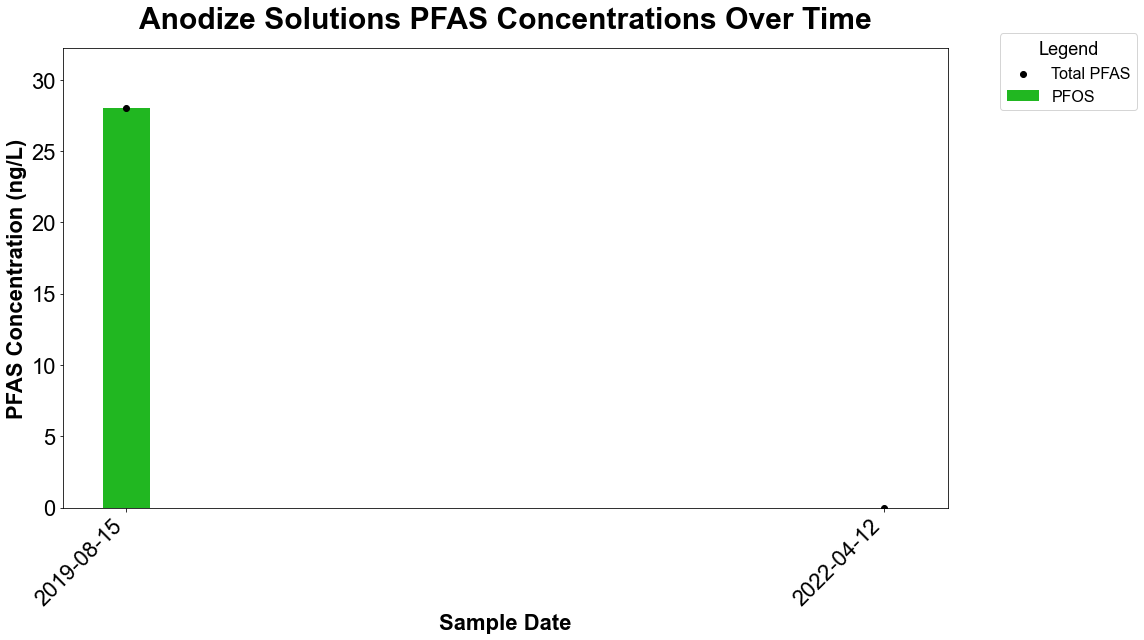

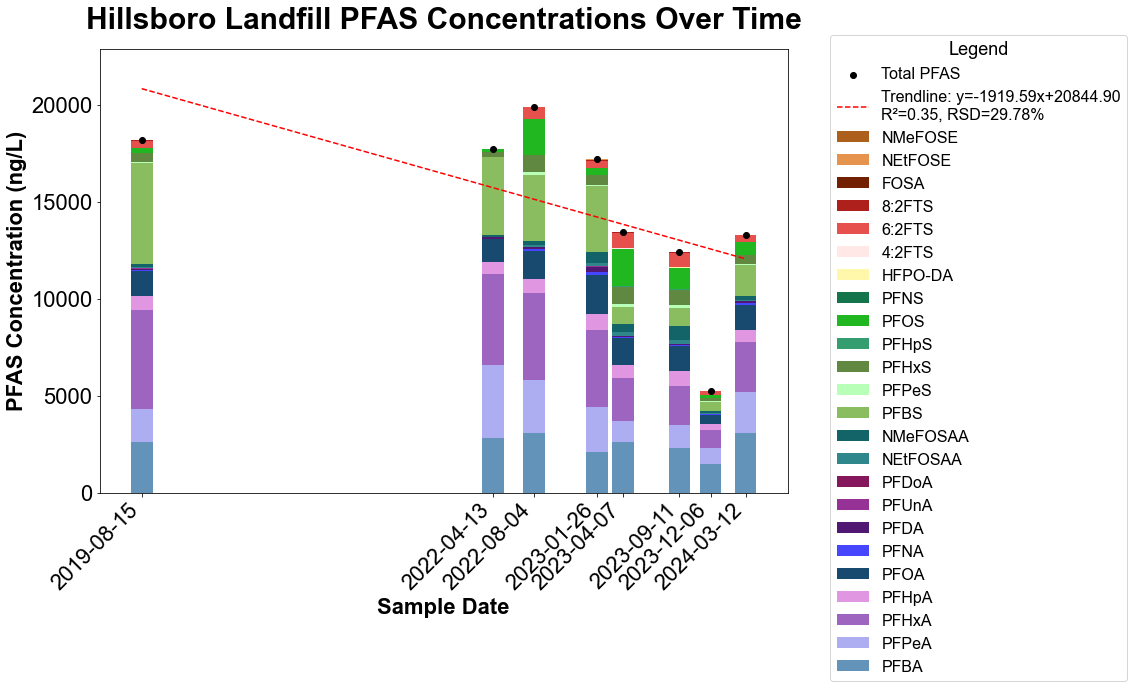

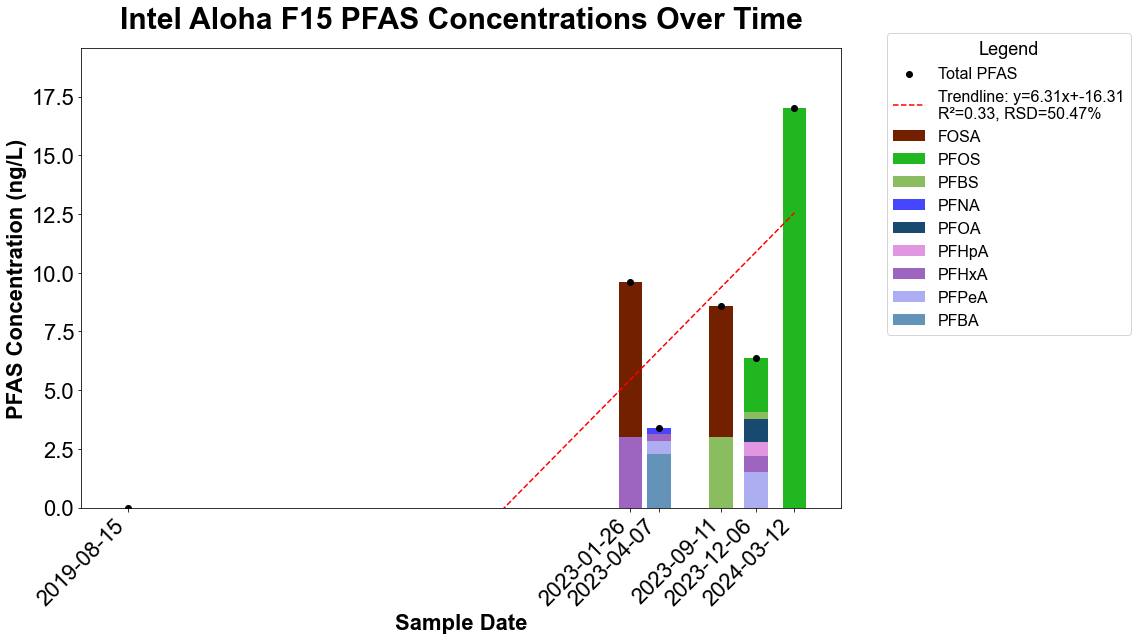

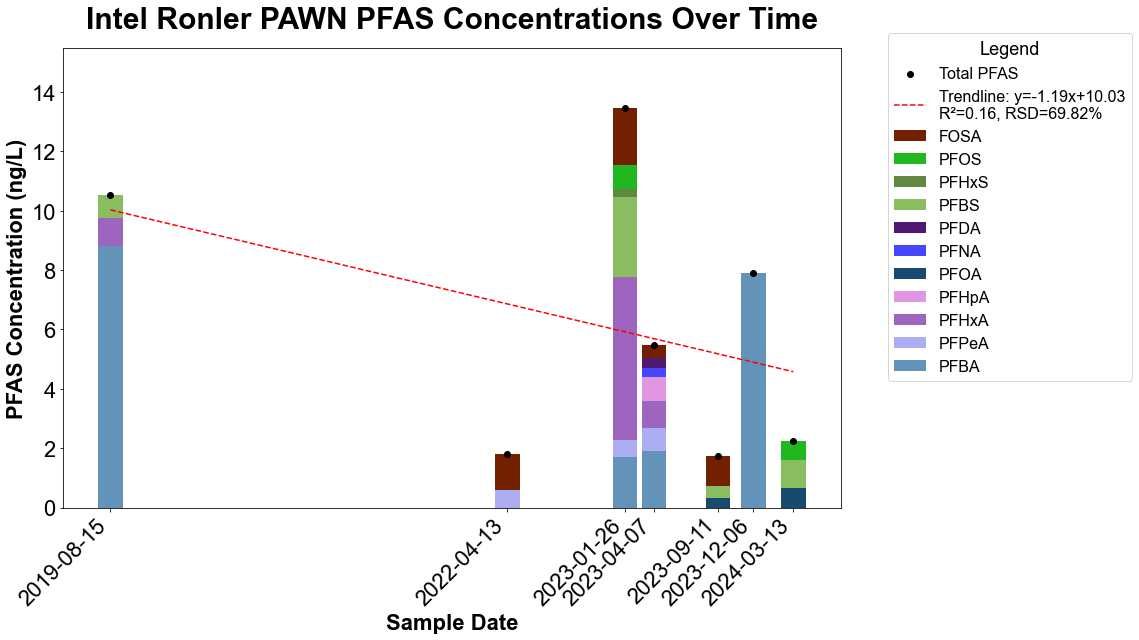

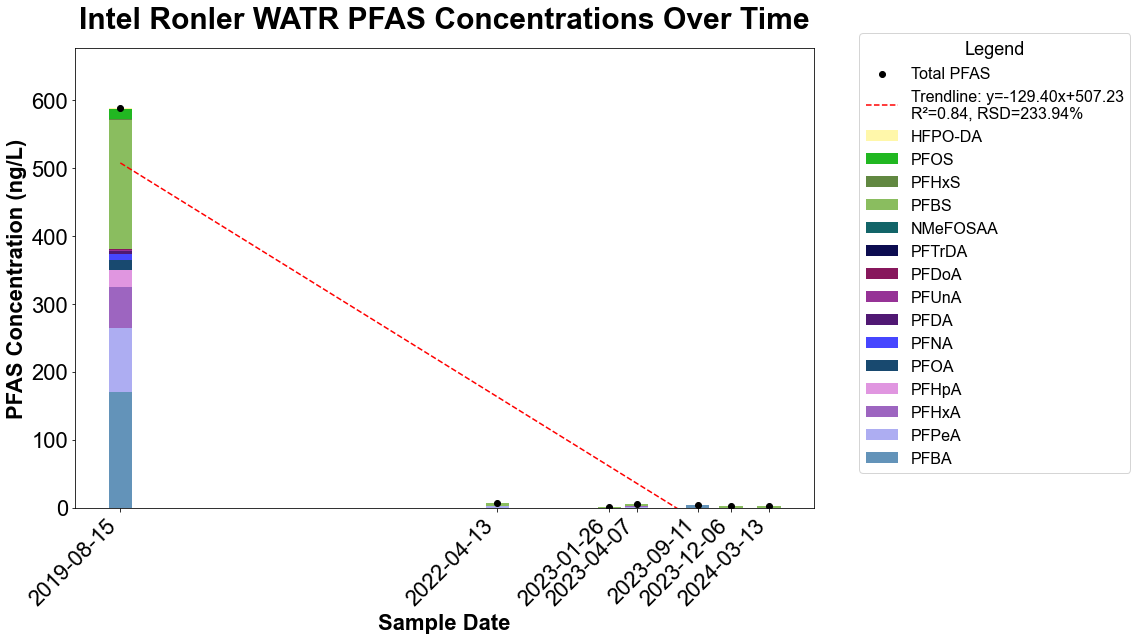

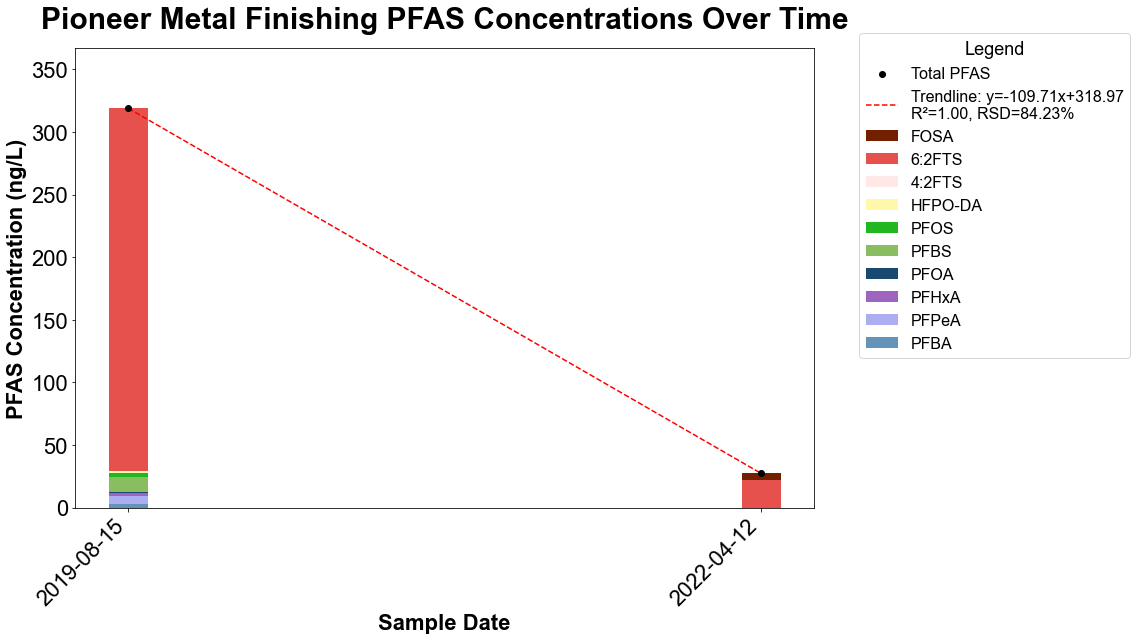

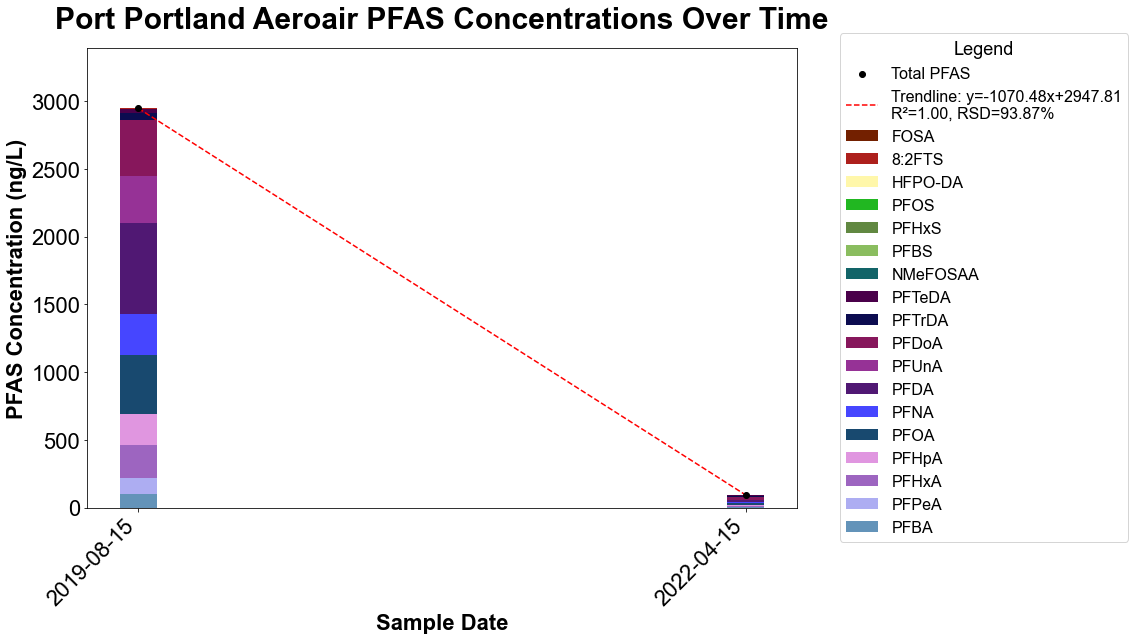

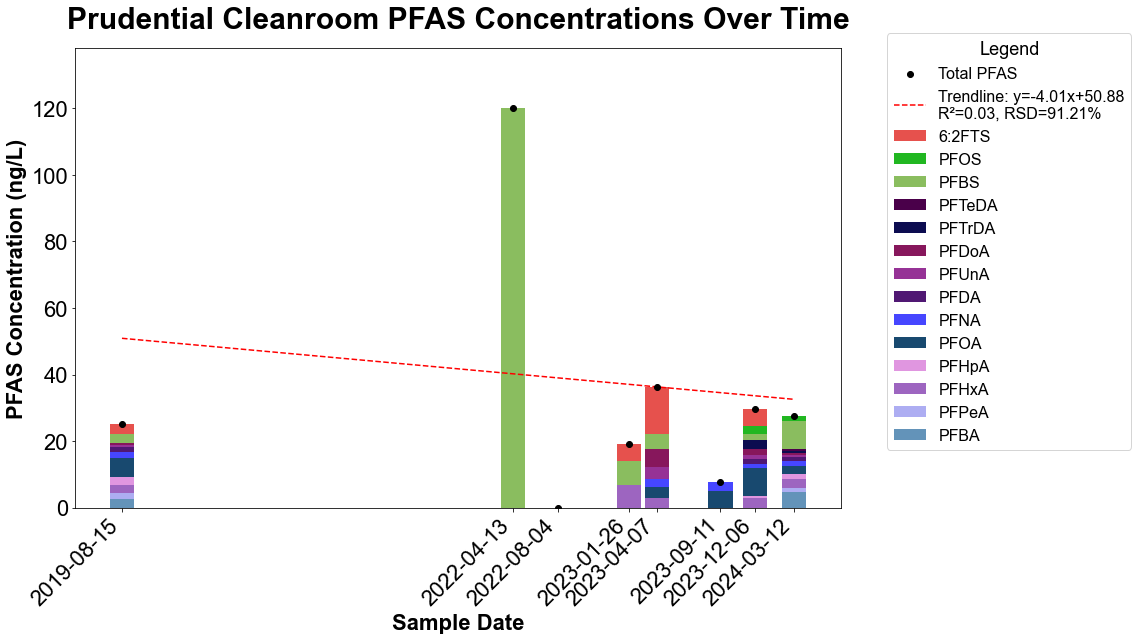

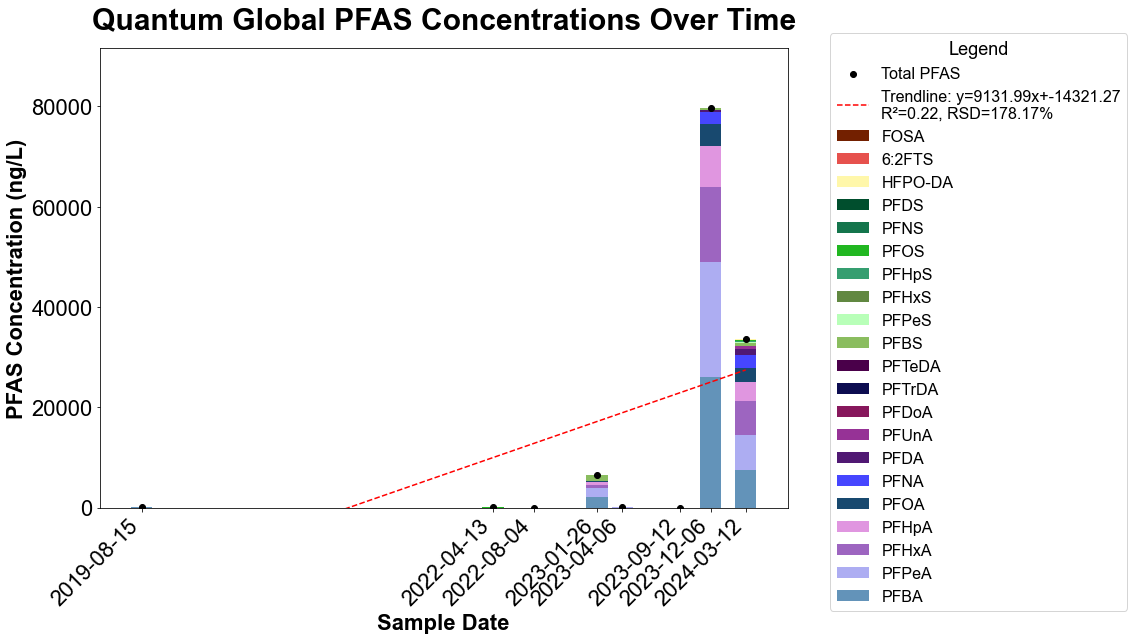

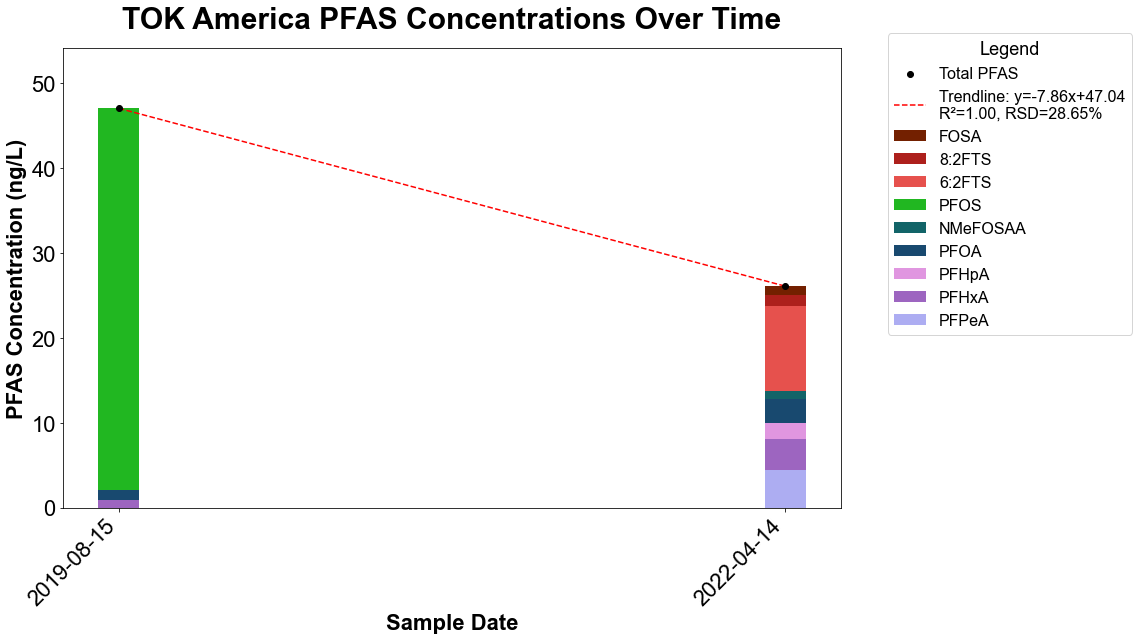

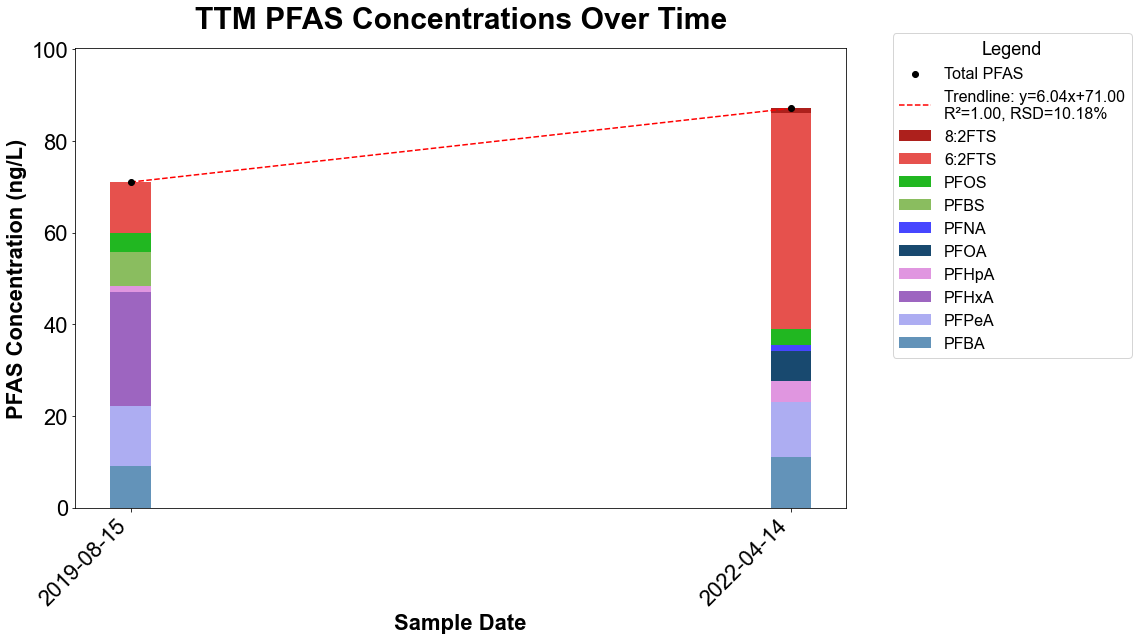

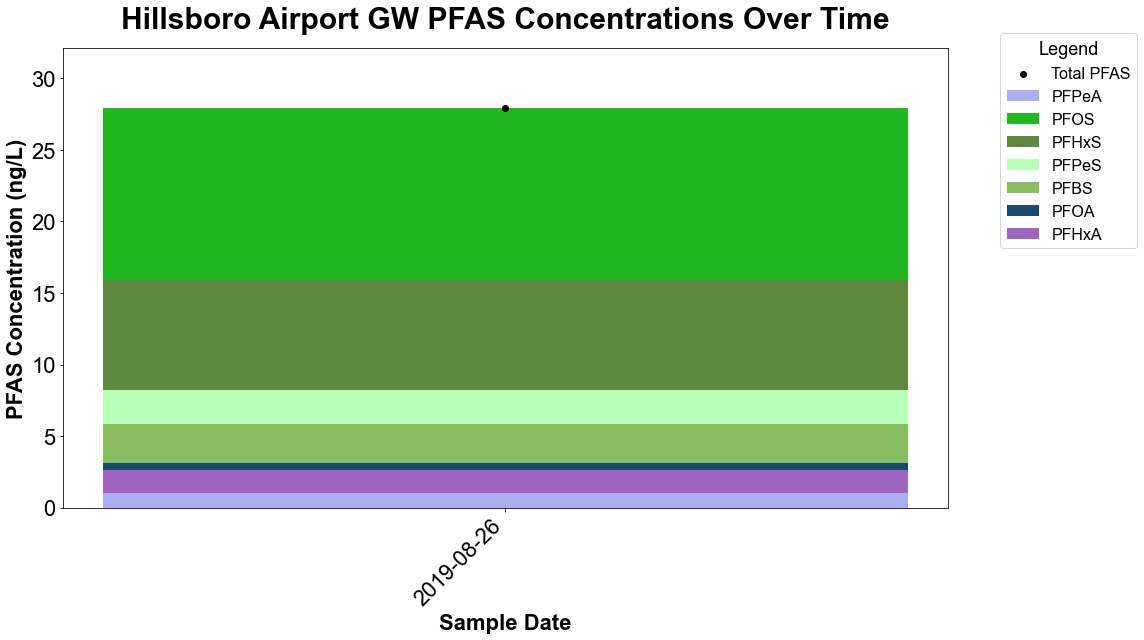

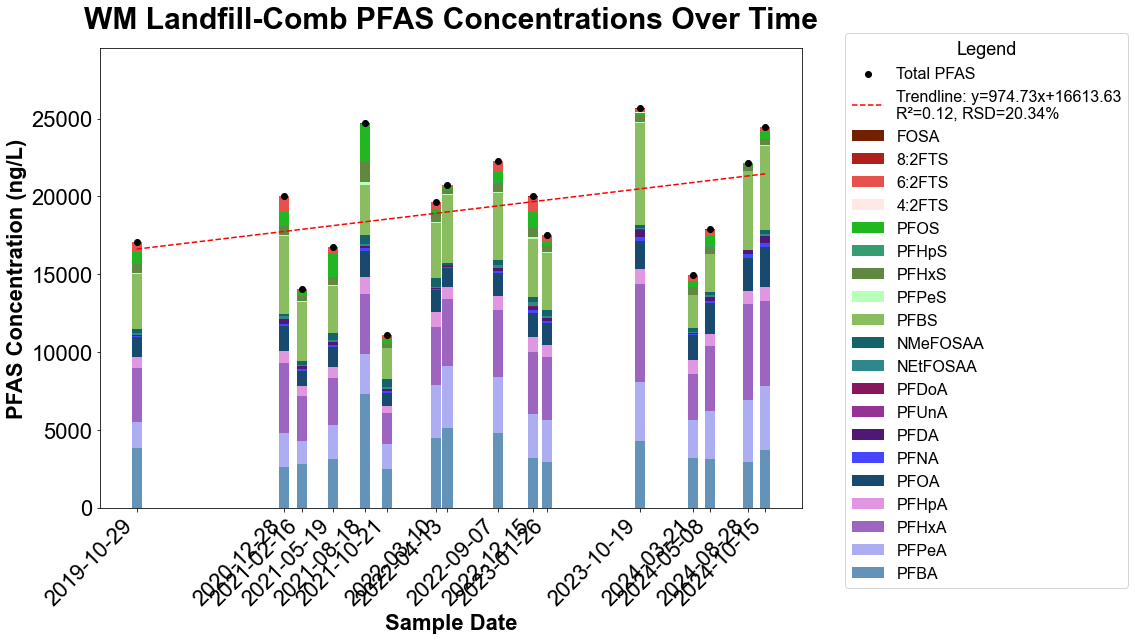

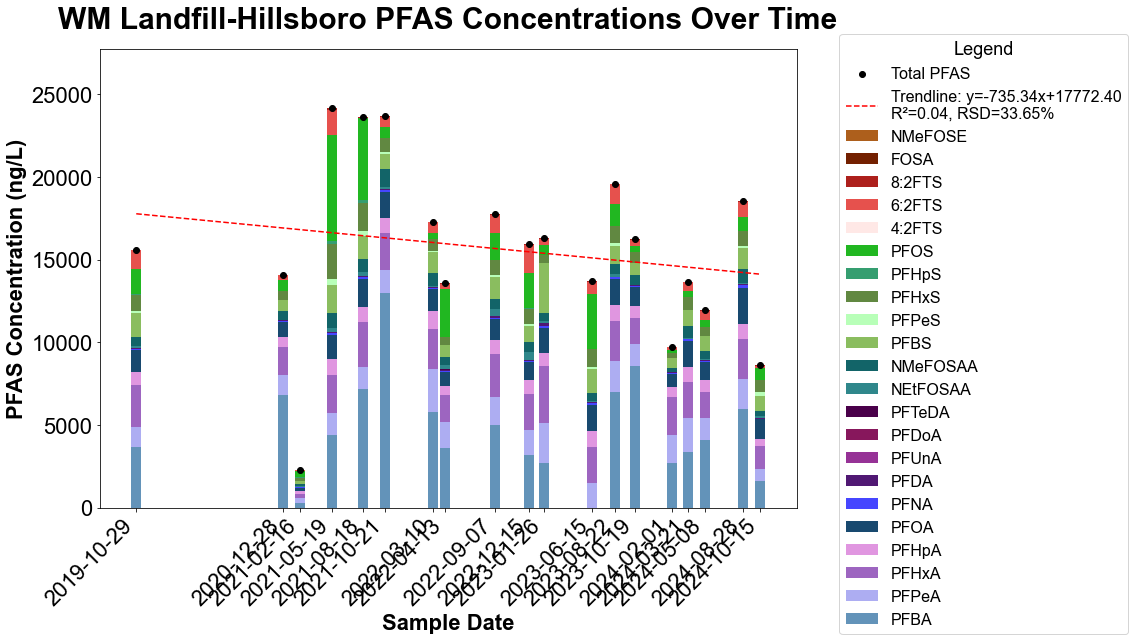

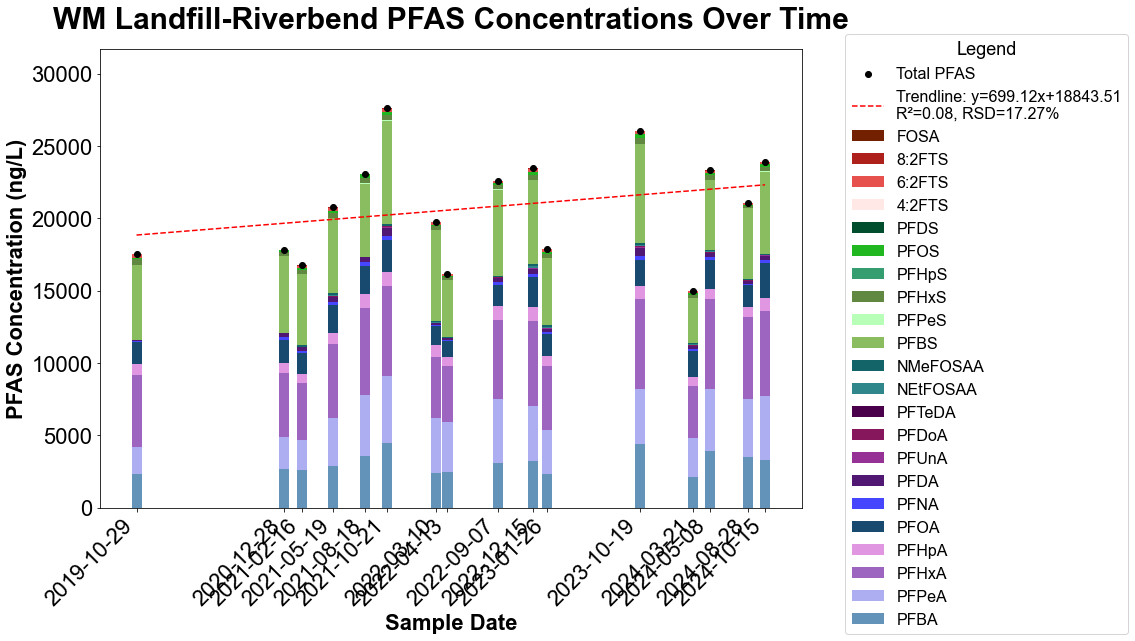

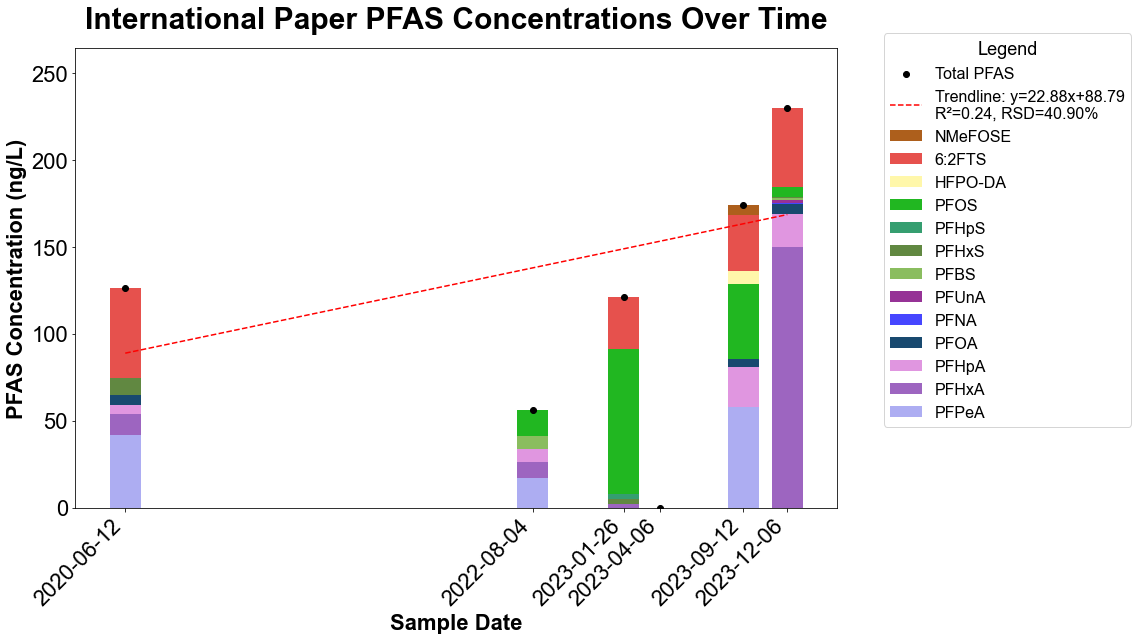

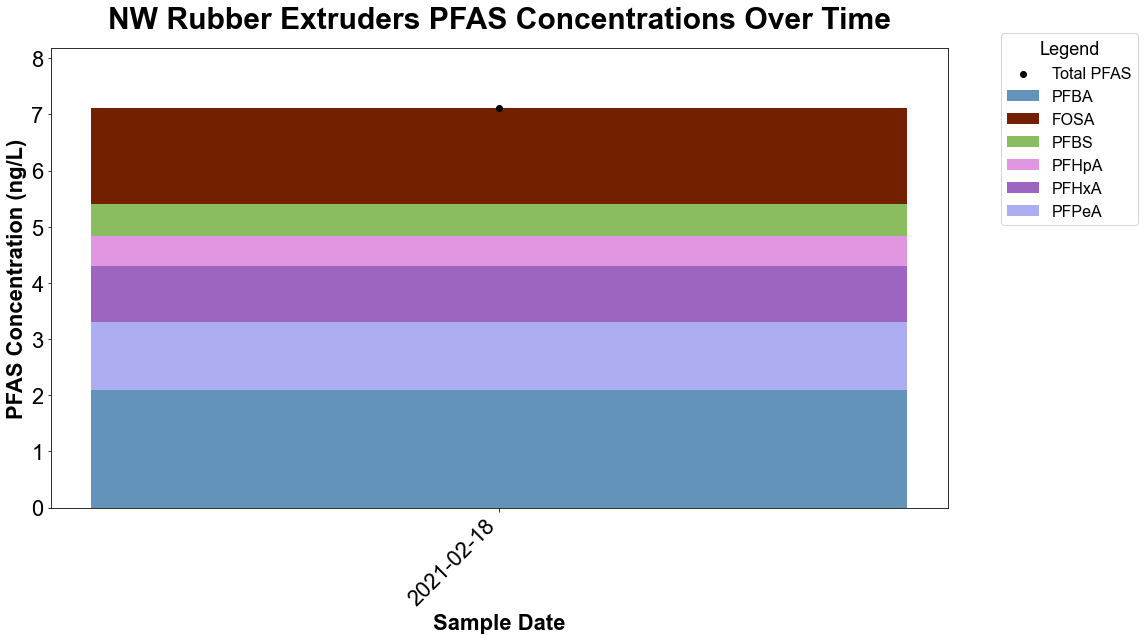

An error occurred: pop from empty list


<ipython-input-169-5b1f4fa033ca>:63: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim(0, ylim)


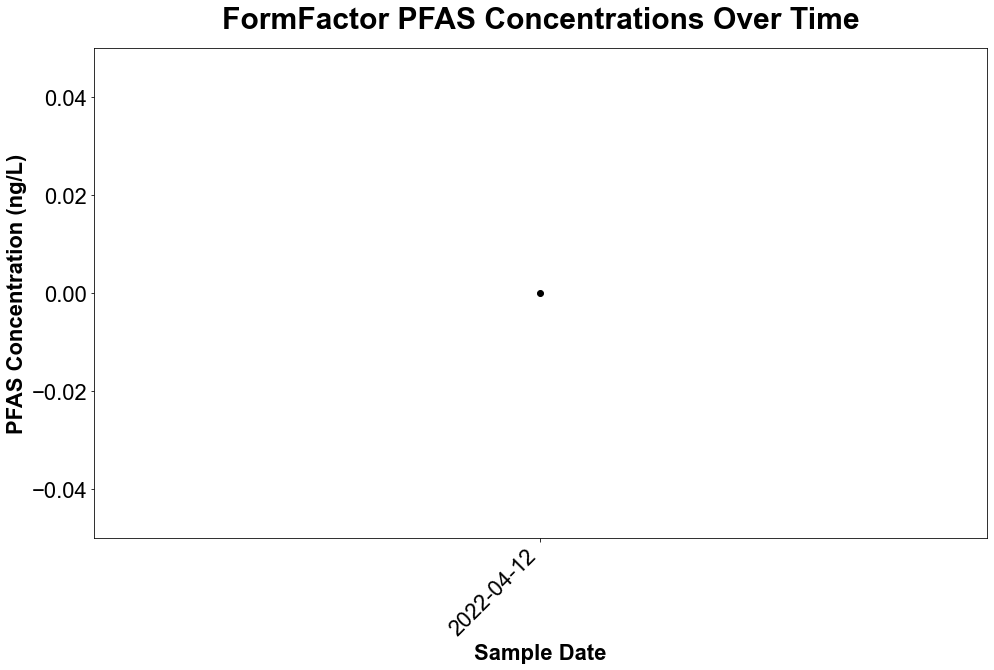

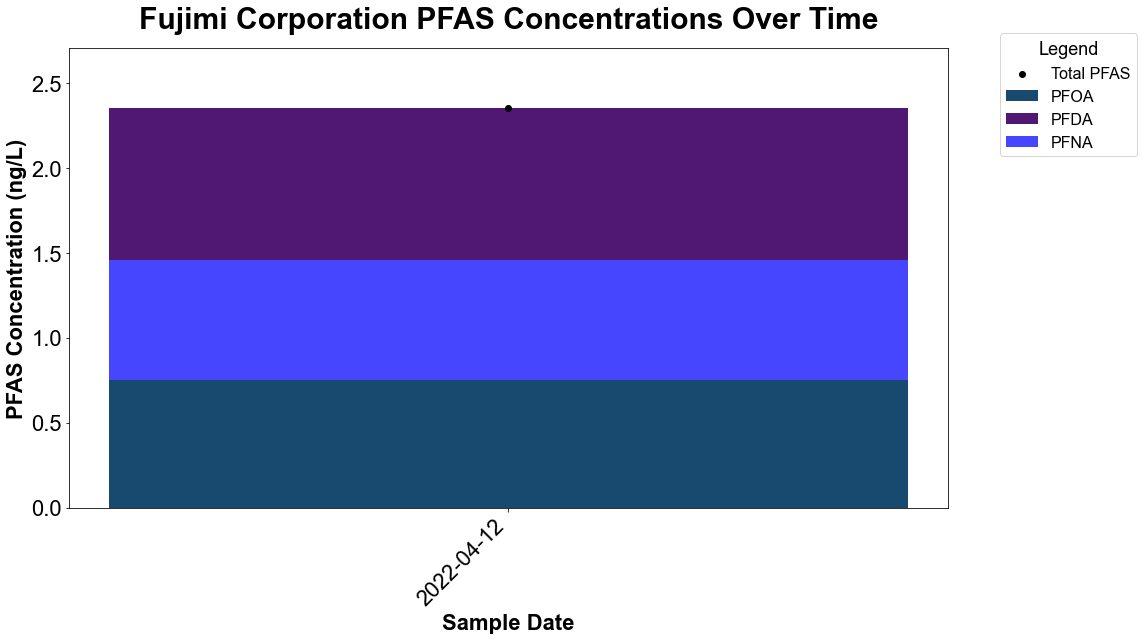

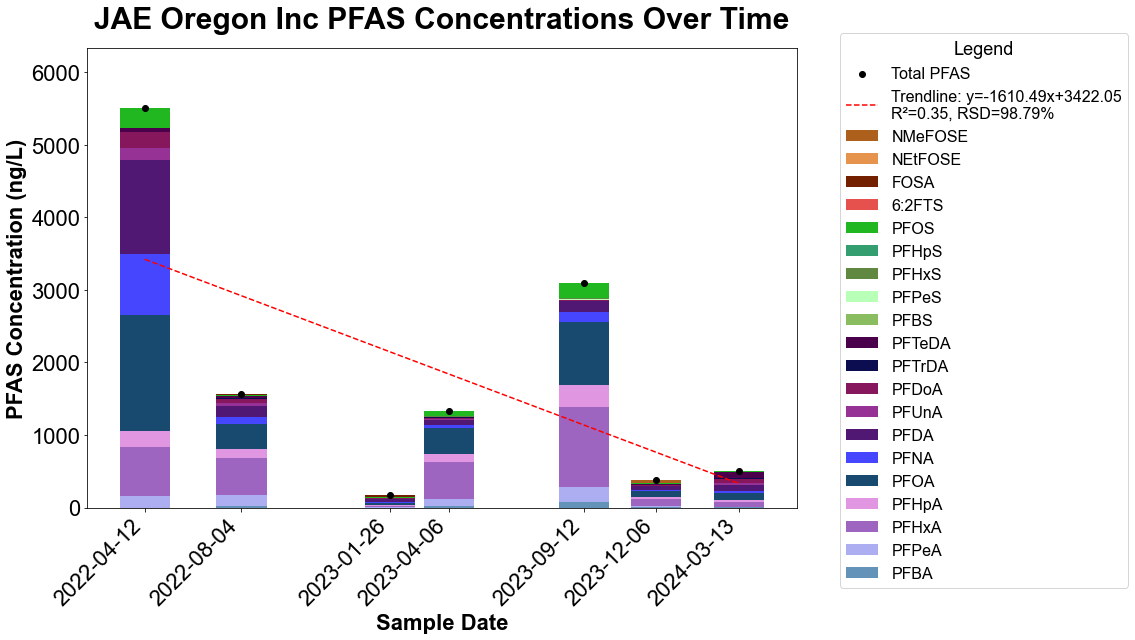

<ipython-input-169-5b1f4fa033ca>:63: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim(0, ylim)


An error occurred: pop from empty list


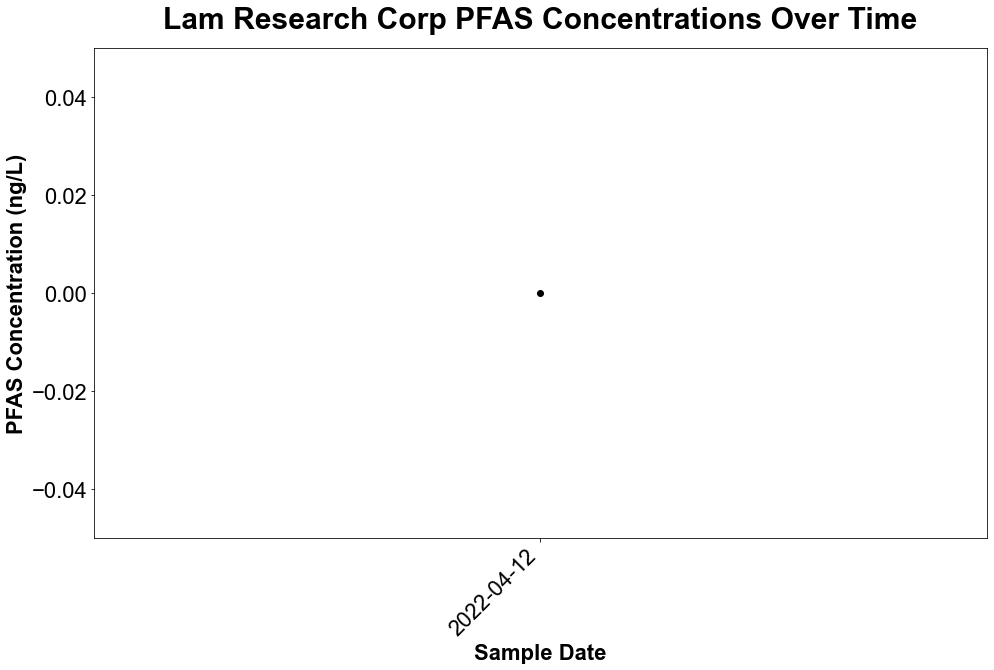

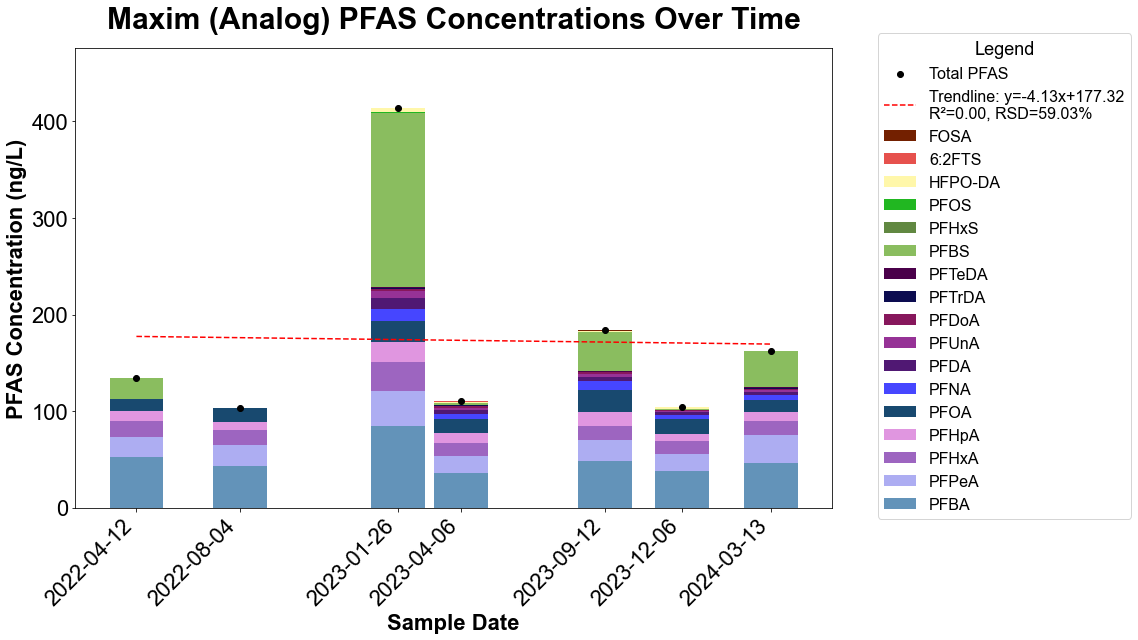

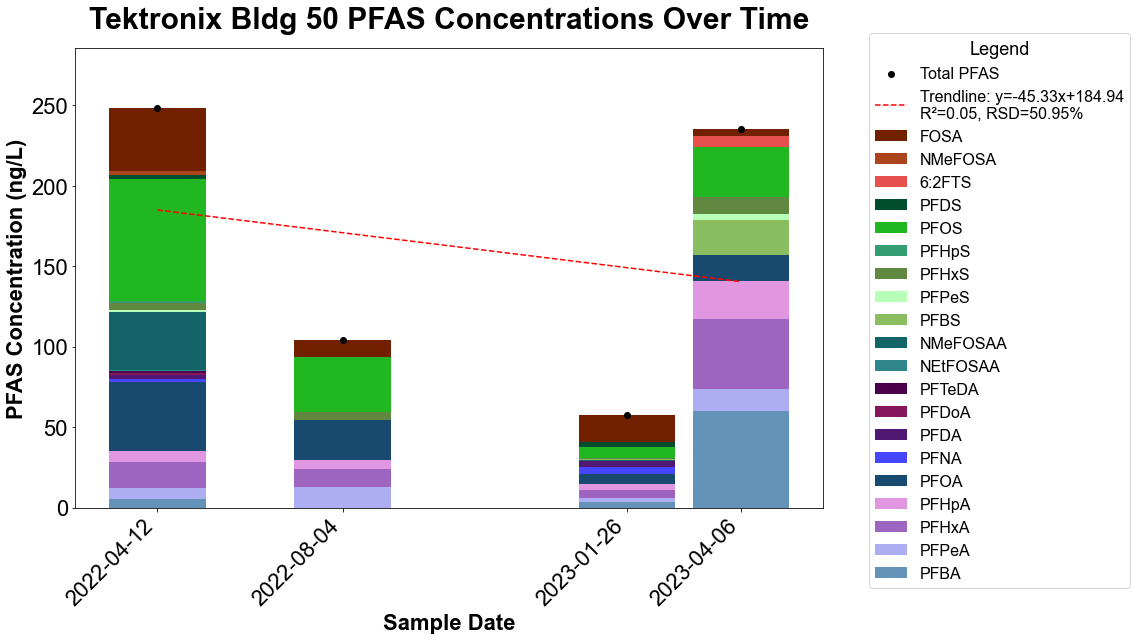

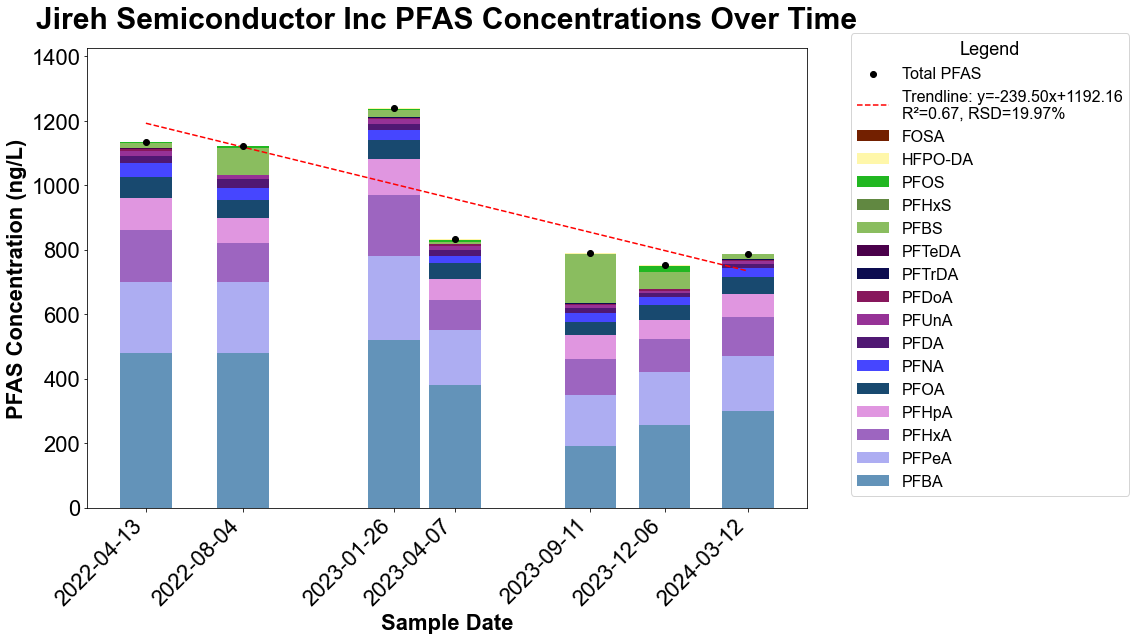

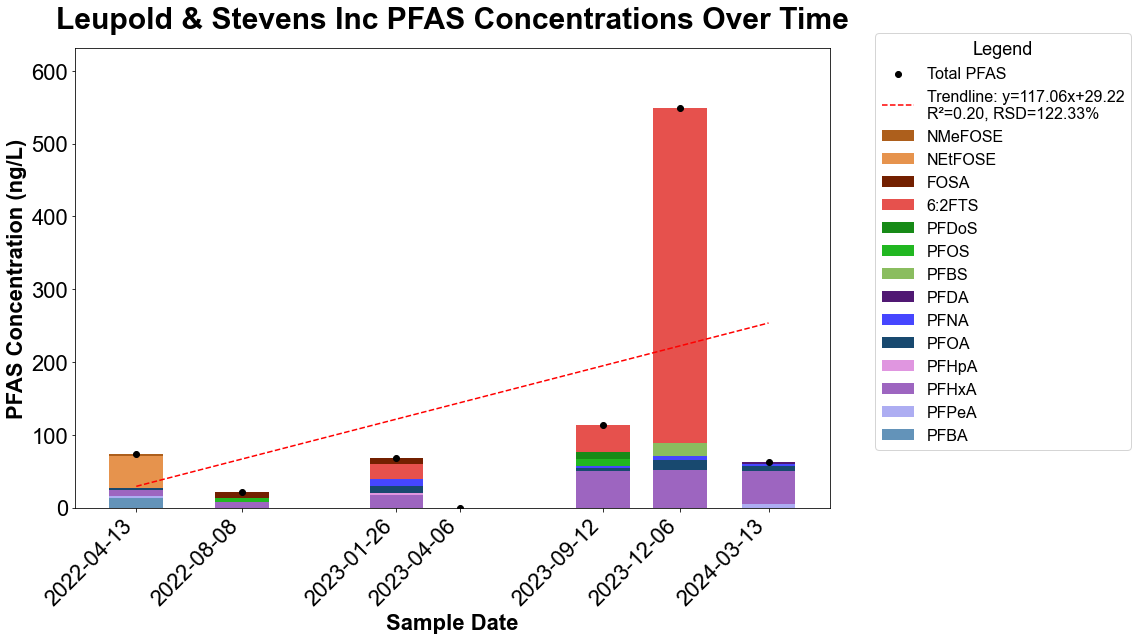

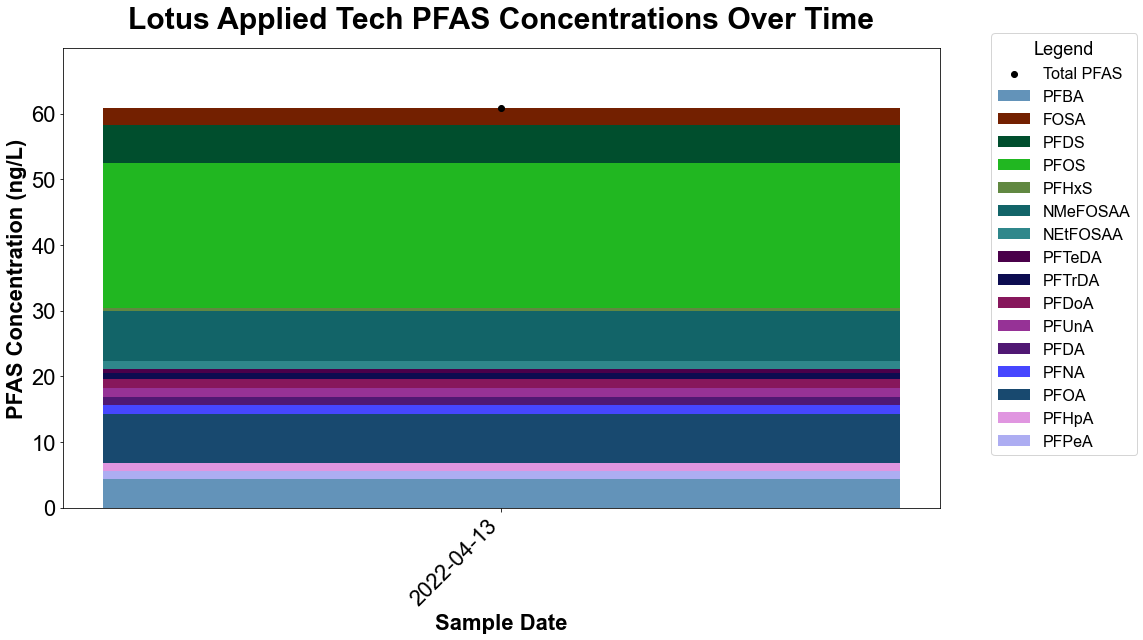

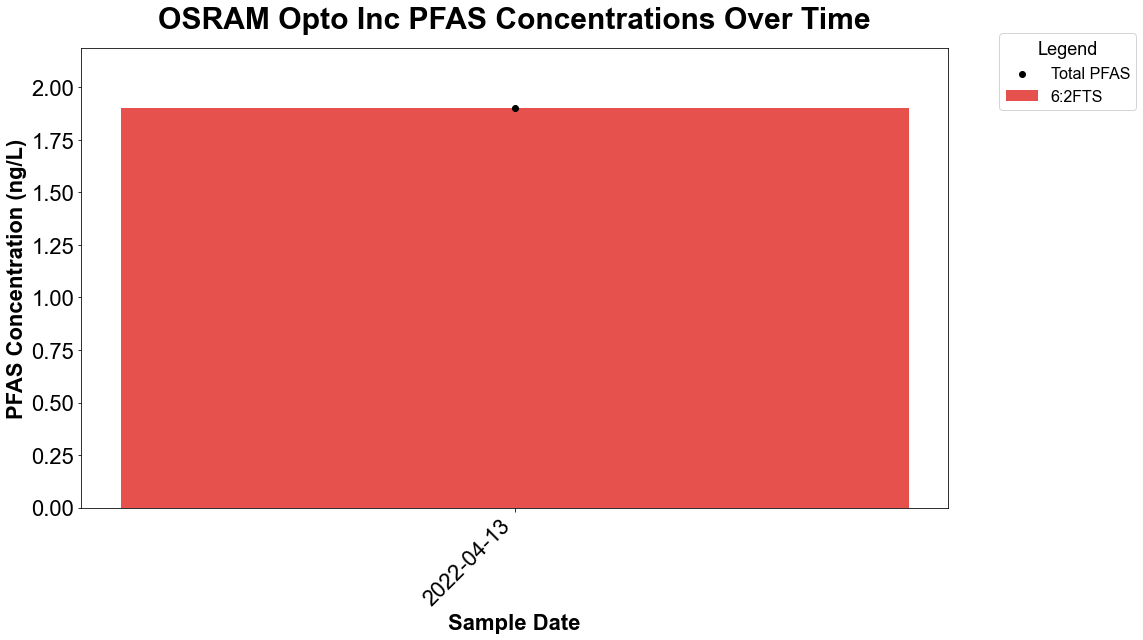

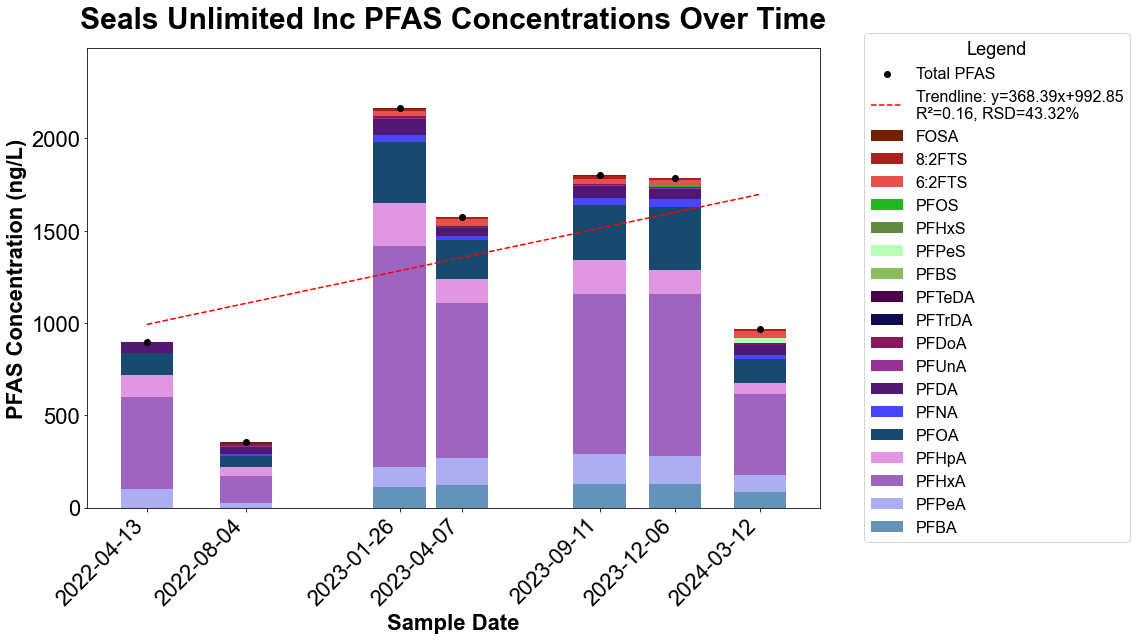

<ipython-input-169-5b1f4fa033ca>:63: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim(0, ylim)
<ipython-input-169-5b1f4fa033ca>:63: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim(0, ylim)


An error occurred: pop from empty list
An error occurred: pop from empty list


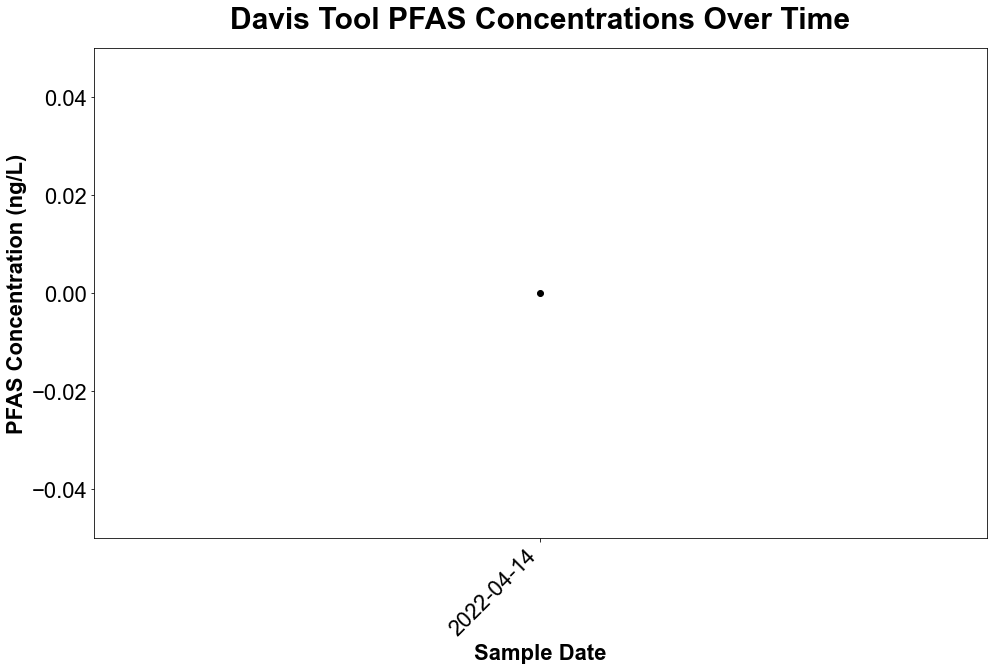

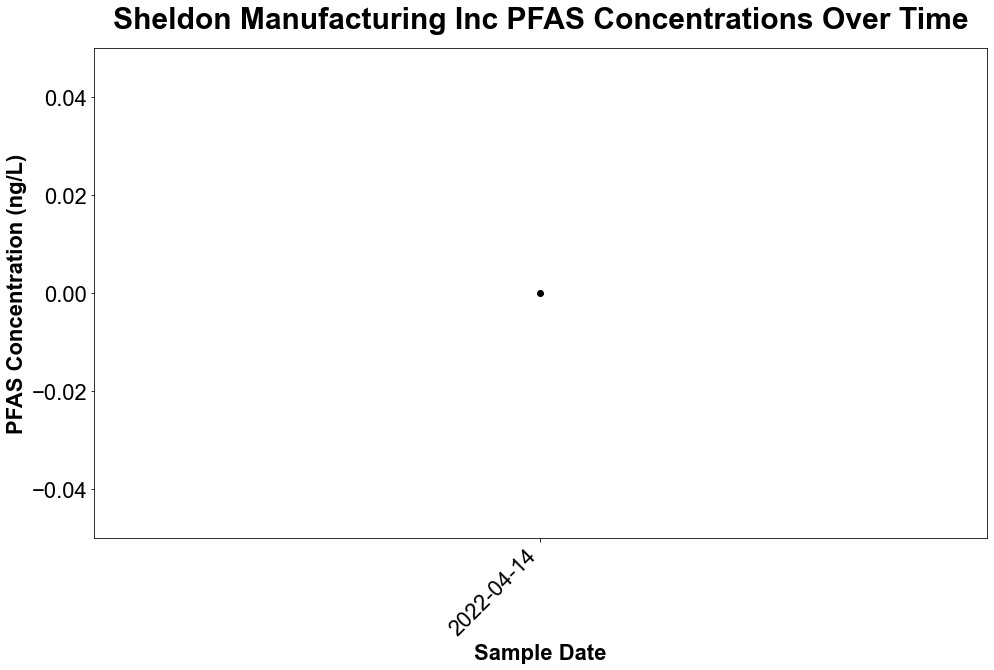

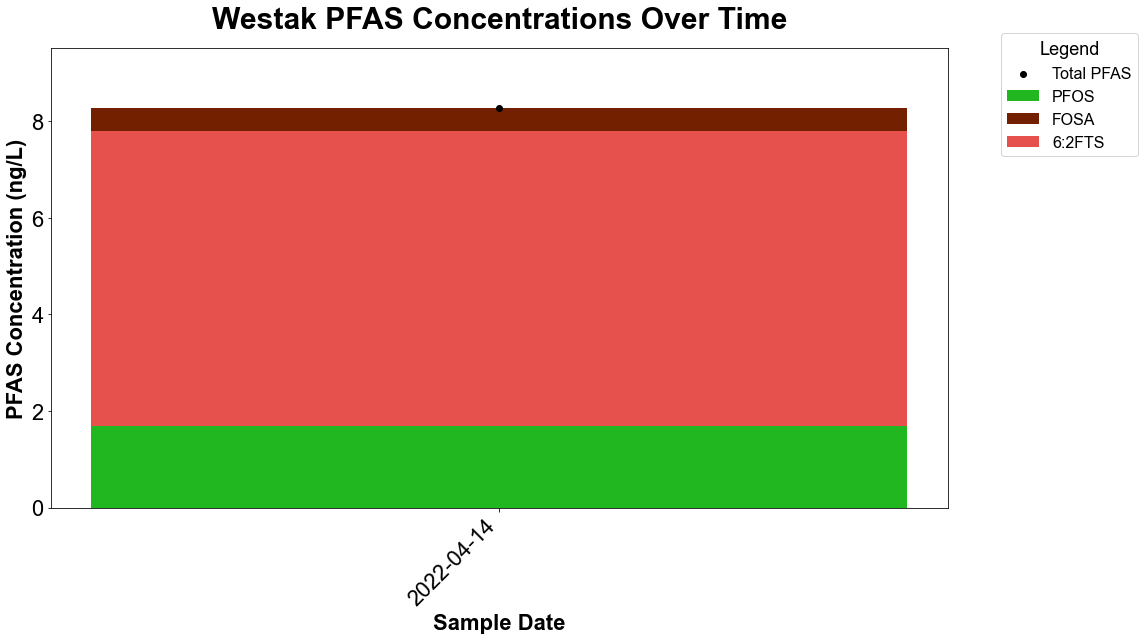

In [173]:
#filtered_df.loc[(filtered_df['Sample Date'] > '2019-08-15')] to exclude Interl WATR Aug 2019 sample
for location in sample_locations:
    avg_pivot_table, count_pivot_table, std_dev_pivot_table=create_filtered_pivot_tables(data_df=filtered_df, sample_location=[location], qual_summary=None, type=None, pfas_compound=None)
    avg_pivot_table.columns = avg_pivot_table.columns.map(pfas_mapping)

    # Filter the desired_order to only include columns that exist in df
    filtered_order = [comp for comp in desired_order if comp in avg_pivot_table.columns]
    # Reorder columns by indexing df with the desired order
    avg_pivot_table = avg_pivot_table[filtered_order]

    new_indexes=[]
    for index in avg_pivot_table.index:
        new_index= str(index).replace(' 00:00:00','')
        new_indexes.append(new_index)
    avg_pivot_table.index=new_indexes

    for column in avg_pivot_table.columns:
        if avg_pivot_table[column].sum() == 0:
            avg_pivot_table.drop(column, axis=1,inplace=True)

    TotalPFAS=pd.DataFrame(avg_pivot_table.sum(axis=1), columns=['Total PFAS'])

    maximum=TotalPFAS.max()*1.15
    maximum=maximum.iloc[0]
    
    title=location+" PFAS Concentrations Over Time"
    #standard size (16,9)
    create_stacked_bar_chart_filtered(avg_pivot_table=avg_pivot_table, std_dev_pivot_table=None, add_data_table=TotalPFAS, figsize=(16, 9),title=title, 
                                      compound_colors_dict=compound_colors_dict_abbrev,title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, 
                                      legend_fontsize=16, ylim=maximum)

### Relative Standard Deviation for Combination of Sample Location and Individual PFAS Compound

#### Functions

In [183]:
def create_filtered_pivot_tables(data_df, filter_qual_summary=None, filter_pfas_compound=None,
                              filter_sample_location=None, start_date=None, end_date=None,col_name= 'Quant Incl Estimates Incl Qual Flags'):
    """
    Create a custom pivot table with filters based on 'Qual Summary (Grade for filtering)', 'PFAS Compound',
    'Sample Location', and a date range for 'Sample Date'.

    Args:
        data_df (pd.DataFrame): The DataFrame containing the data.
        filter_qual_summary (list of str, optional): List of 'Qual Summary (Grade for filtering)' values to filter the data (default is None).
        filter_pfas_compound (list of str, optional): List of 'PFAS Compound' values to filter the data (default is None).
        filter_sample_location (list of str, optional): List of 'Sample Location' values to filter the data (default is None).
        start_date (str, optional): Start date for the date range filter (default is None).
        end_date (str, optional): End date for the date range filter (default is None).

    Returns:
        pd.DataFrame: The custom pivot table.
    """
    try:
        # Apply filters based on 'Qual Summary (Grade for filtering)'
        filtered_data = data_df
        if filter_qual_summary:
            filtered_data = filtered_data[filtered_data['Qual Summary (Grade for filtering)'].isin(filter_qual_summary)]

        # Apply filters based on 'PFAS Compound'
        if len(filter_pfas_compound) > 0:
            filtered_data = filtered_data[filtered_data['PFAS Compound'].isin(filter_pfas_compound)]

        # Apply filters based on 'Sample Location'
        if len(filter_sample_location) >0:
            filtered_data = filtered_data[filtered_data['Sample Location'].isin(filter_sample_location)]

        # Apply date range filter based on 'Sample Date'
        if start_date and end_date:
            filtered_data = filtered_data[(filtered_data['Sample Date'] >= start_date) & (filtered_data['Sample Date'] <= end_date)]

        # Create a pivot table with 'Sample Location' as rows, 'PFAS Compound' as columns, and average of 'Quant Incl Estimates Incl Qual Flags' as values
        avg_pivot_table = pd.pivot_table(filtered_data, values=col_name,
                                     index='Sample Location', columns='PFAS Compound', aggfunc='mean', fill_value=np.nan)
        # Create a pivot table with 'Sample Location' as rows, 'PFAS Compound' as columns, and average of 'Quant Incl Estimates Incl Qual Flags' as values
        count_pivot_table = pd.pivot_table(filtered_data, values=col_name,
                                     index='Sample Location', columns='PFAS Compound', aggfunc='count', fill_value=0)
        # Create a pivot table with 'Sample Location' as rows, 'PFAS Compound' as columns, and average of 'Quant Incl Estimates Incl Qual Flags' as values
        std_dev_pivot_table = pd.pivot_table(filtered_data, values=col_name,
                                     index='Sample Location', columns='PFAS Compound', aggfunc='std', fill_value=np.nan)

        return avg_pivot_table, count_pivot_table, std_dev_pivot_table

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

#### Create Tables

In [188]:
filtered_data_No0s = filtered_df[filtered_df['Quant Incl Estimates Incl Qual Flags'] != 0]
#Change data_df to filtered_data_No0s for exclusing 0s or otherwise use filtered_df
avg_pivot_table, count_pivot_table, std_dev_pivot_table=create_filtered_pivot_tables(data_df=filtered_data_No0s, filter_qual_summary=qual_grades, filter_pfas_compound=compounds,
                              filter_sample_location=sample_locations, start_date=None, end_date=None,col_name= 'Quant Incl Estimates Incl Qual Flags')
avg_pivot_table

PFAS Compound,4:2 Fluorotelomersulfonic acid,6:2 Fluorotelomersulfonic acid,8:2 Fluorotelomersulfonic acid,HFPO-DA,NEtFOSAA,NEtFOSE,NMeFOSA,NMeFOSAA,NMeFOSE,Perfluorobutanesulfonic acid,...,Perfluorononanesulfonic acid,Perfluorononanoic acid,Perfluorooctanesulfonamide,Perfluorooctanesulfonic acid (PFOS),Perfluorooctanoic acid (PFOA),Perfluoropentanesulfonic acid,Perfluoropentanoic acid,Perfluorotetradecanoic acid,Perfluorotridecanoic acid,Perfluoroundecanoic acid
Sample Location,,,,,,,,,,,,,,,,,,,,,
Anodize Solutions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,28.000000,NaN,NaN,NaN,NaN,NaN,NaN
Fujimi Corporation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.710000,NaN,NaN,0.750000,NaN,NaN,NaN,NaN,NaN
Hillsboro Airport GW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.700000,...,NaN,NaN,NaN,12.000000,0.510000,2.400000,1.000000,NaN,NaN,NaN
Hillsboro Landfill,11.275000,452.500000,34.250000,59.000,92.000000,12.0,NaN,300.666667,9.933333,2264.444444,...,3.2,81.250000,7.120000,733.333333,1205.555556,84.500000,1838.888889,NaN,NaN,8.820000
Intel Aloha F15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.660000,...,NaN,0.240000,6.100000,9.650000,0.980000,NaN,1.015000,NaN,NaN,NaN
Intel Ronler PAWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.210000,...,NaN,0.290000,1.130000,0.735000,0.495000,NaN,0.646667,NaN,NaN,NaN
Intel Ronler WATR,NaN,NaN,NaN,1.300,NaN,NaN,NaN,0.780000,NaN,33.846667,...,NaN,8.500000,NaN,15.000000,8.245000,NaN,32.433333,NaN,0.550000,1.700000
International Paper,NaN,39.750000,NaN,7.600,NaN,NaN,NaN,NaN,5.600000,4.245000,...,NaN,0.560000,NaN,36.750000,5.233333,NaN,39.000000,NaN,NaN,2.100000
JAE Oregon Inc,NaN,1.600000,NaN,NaN,NaN,3.3,NaN,NaN,43.000000,1.140000,...,NaN,164.142857,13.120000,86.857143,483.714286,2.420000,91.485714,31.000000,9.950000,37.642857


In [189]:
#Change data_df to filtered_data_No0s for exclusing 0s or otherwise use filtered_df
avg_pivot_table, count_pivot_table, std_dev_pivot_table=create_filtered_pivot_tables(data_df=filtered_data_No0s, filter_qual_summary=qual_grades, filter_pfas_compound=compounds,
                              filter_sample_location=sample_locations, start_date=None, end_date=None,col_name= 'Quant Incl Estimates Incl Qual Flags')

avg_pivot_table.columns = avg_pivot_table.columns.map(pfas_mapping)

# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in avg_pivot_table.columns]
# Reorder columns by indexing df with the desired order
avg_pivot_table = avg_pivot_table[filtered_order]

count_pivot_table.columns = count_pivot_table.columns.map(pfas_mapping)

# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in count_pivot_table.columns]
# Reorder columns by indexing df with the desired order
count_pivot_table = count_pivot_table[filtered_order]

std_dev_pivot_table.columns = std_dev_pivot_table.columns.map(pfas_mapping)

# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in std_dev_pivot_table.columns]
# Reorder columns by indexing df with the desired order
std_dev_pivot_table = std_dev_pivot_table[filtered_order]

avg_pivot_table, std_dev_pivot_table = avg_pivot_table.align(std_dev_pivot_table, join="left")


In [191]:
RSD_pivot_table=std_dev_pivot_table/avg_pivot_table*100
RSD_pivot_table

PFAS Compound,PFBA,PFPeA,PFHxA,PFHpA,PFOA,PFNA,PFDA,PFUnA,PFDoA,PFTrDA,...,PFDS,PFDoS,HFPO-DA,4:2FTS,6:2FTS,8:2FTS,NMeFOSA,FOSA,NEtFOSE,NMeFOSE
Sample Location,,,,,,,,,,,,,,,,,,,,,
Anodize Solutions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fujimi Corporation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hillsboro Airport GW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hillsboro Landfill,25.259074,54.040021,53.912583,32.073125,39.422987,60.766143,88.225658,90.064362,38.876787,NaN,...,NaN,NaN,NaN,39.381388,51.851351,34.495005,NaN,21.355705,NaN,56.960060
Intel Aloha F15,NaN,67.575722,109.187053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.591914,NaN,NaN
Intel Ronler PAWN,74.883329,16.679062,107.021798,NaN,49.997449,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.042715,NaN,NaN
Intel Ronler WATR,136.035430,164.402263,135.075526,160.735150,133.016691,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
International Paper,NaN,52.984560,164.018727,64.306365,9.030221,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26.494838,NaN,NaN,NaN,NaN,NaN
JAE Oregon Inc,111.841839,88.757552,92.549322,98.876555,117.596703,180.693433,174.229219,157.131065,134.727427,76.757869,...,NaN,NaN,NaN,NaN,70.710678,NaN,NaN,84.312424,NaN,NaN


In [ ]:
#dfs: A dictionary where keys are the tab names and values are the DataFrames to write.
dfs = {'RSDs': RSD_pivot_table}

#filename: The name of the Excel file to write to.
filename= 'Industries_Compodounds RSD.xlsx'
dfs_to_excel(dfs, filename)

File 'Industries_Compodounds RSD.xlsx' has been written with 1 tabs.
